<a href="https://colab.research.google.com/github/PaulaOlivio/PythonRobotics/blob/master/Copy_of_4_2_Traffic_Sign_Classification_AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import packages

In [0]:
from skimage.transform import resize
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import csv
import os

%matplotlib inline

## Import the data


In [0]:
if not os.path.isdir("GTSRB"):
  !wget http://benchmark.ini.rub.de/Dataset/GTSRB-Training_fixed.zip
  !unzip -q GTSRB-Training_fixed.zip
  !rm GTSRB-Training_fixed.zip
  

def readTrafficSigns(rootpath):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    labels = [] # corresponding labels
    # loop over all 42 classes
    for c in range(0,10):
        prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
        gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        next(gtReader) # skip header
        # loop over all images in current annotations file
        i = 0
        for row in gtReader:
          if i == 100:
            break
          i+=1
          images.append(resize(plt.imread(prefix + row[0]),(224,224)).astype(np.float32)) # the 1th column is the filename
          labels.append(row[7]) # the 8th column is the label
        gtFile.close()
    return images, labels

images,labels = readTrafficSigns('./GTSRB/Training')
labels=np.eye(10)[np.array(labels).astype(int)].astype(np.float32)

random_idx = np.random.choice(len(labels), len(labels), replace=False)

images = np.array(images)[random_idx]
labels = np.array(labels)[random_idx]
class_names = ["20km/h","30km/h","50km/h","60km/h","70km/h","80km/h","Not 80km/h","100km/h","120km/h","2 Cars"]

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


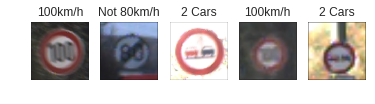

In [0]:
n_samples = 5 #from 1 to 9
#Show some random data from train
for i,j in enumerate(np.random.randint(len(images), size=n_samples)):
  plt.subplot(100+i+1+10*n_samples)
  plt.imshow(images[j])
  plt.axis('off')
  plt.title(class_names[labels[j].argmax()])
  
plt.show()

## Helpers

In [0]:
def weight_variable(shape):
  return tf.Variable(tf.truncated_normal(shape, stddev=0.1))

def bias_variable(shape):
  return tf.Variable(tf.constant(0.0, shape=shape))

## Setting hyper parameters

In [0]:
n_classes = 10
learning_rate = 10**-3
epochs = 8
batch_size = 16
drop_out = .5

## Neural Network Constructor

In [0]:
## Alexnet

tf.reset_default_graph()

# variables
x = tf.placeholder("float", shape=[None, 224, 224, 3], name="X")
y_ = tf.placeholder("float", shape=[None, n_classes], name="Labels")
keep_prob = tf.placeholder(tf.float32)
lr = tf.placeholder(tf.float32)

kernel1 = weight_variable([11, 11, 3, 96])
bias1 = bias_variable([96])
conv1 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(x, kernel1,[1,4,4,1],'SAME'), bias1))
lrn1 = tf.nn.local_response_normalization(conv1, alpha=1e-4, beta=0.75, depth_radius=2, bias=2.0)
pool1 = tf.nn.max_pool(lrn1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='VALID')

kernel2 = weight_variable([5, 5, 96, 256])
bias2 = bias_variable([256])
conv2 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(pool1, kernel2,[1,1,1,1],'SAME'), bias2))
lrn2 = tf.nn.local_response_normalization(conv2, alpha=1e-4, beta=0.75, depth_radius=2, bias=2.0)
pool2 = tf.nn.max_pool(lrn2, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='VALID')

kernel3 = weight_variable([3, 3, 256, 384])
bias3 = bias_variable([384])
conv3 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(pool2, kernel3,[1,1,1,1],'SAME'), bias3))

kernel4 = weight_variable([3, 3, 384, 384])
bias4 = bias_variable([384])
conv4 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(conv3, kernel4,[1,1,1,1],'SAME'), bias4))

kernel5 = weight_variable([3, 3, 384, 256])
bias5 = bias_variable([256])
conv5 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(conv4, kernel5,[1,1,1,1],'SAME'), bias5))
pool5 = tf.nn.max_pool(conv5, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='VALID')
flt5 = tf.reshape(pool5, [-1, 6*6*256])

weights6 = weight_variable([6*6*256, 4096])
bias6 = bias_variable([4096])
fc6 = tf.nn.relu(tf.nn.bias_add(tf.matmul(flt5, weights6), bias6))
drop6 = tf.nn.dropout(fc6, keep_prob)

weights7 = weight_variable([4096, 4096])
bias7 = bias_variable([4096])
fc7 = tf.nn.relu(tf.nn.bias_add(tf.matmul(drop6, weights7), bias7))
drop7 = tf.nn.dropout(fc7, keep_prob)

weights8 = weight_variable([4096, n_classes])
bias8 = bias_variable([n_classes])
fc8 = tf.nn.bias_add(tf.matmul(drop7, weights8), bias8)

y = tf.nn.softmax(fc8)

# define the loss function
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=fc8,labels=y_))

# define training step and accuracy
train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# create a saver
saver = tf.train.Saver()

# initialize the graph
init = tf.global_variables_initializer()

## Training

In [0]:
with tf.Session() as sess:
  sess.run(init)
  # train
  print("Starting the training...")
  best_accuracy = 0.0
  for i in range(epochs):
    #shuffle data
    random_idx = np.random.choice(len(labels), len(labels), replace=False)
    train_images = np.array(images)[random_idx]
    train_labels = np.array(labels)[random_idx]
    #Geerate batches
    j=0
    while j+batch_size < len(train_labels):
      #input_images = np.array([resize(plt.imread(path),(28,28)) for path in train_images[j:j+batch_size]])
      input_images = train_images[j:j+batch_size]
      correct_predictions = train_labels[j:j+batch_size]
      sess.run(train_step, feed_dict={x: input_images, y_: correct_predictions, keep_prob: drop_out})#, lr: learning_rate})
      j+=batch_size
    #last batch can be a smaller
    #input_images = np.array([resize(plt.imread(path),(28,28)) for path in train_images[j:len(train_labels)]])
    input_images = train_images[j:len(train_labels)]
    correct_predictions = train_labels[j:len(train_labels)]
    sess.run(train_step, feed_dict={x: input_images, y_: correct_predictions, keep_prob: drop_out})#, lr: learning_rate})
    
    #validation
    if (i+1)%2 == 0:
      test_accuracy = sess.run(accuracy, feed_dict={
      x: input_images, y_: correct_predictions, keep_prob: 1.0})
      print("Epoch %d, training accuracy %g" % (i+1, test_accuracy))
      print("Loss:",sess.run(cross_entropy, feed_dict={x: input_images, y_: correct_predictions, keep_prob: 1.0}))
      if test_accuracy >= best_accuracy:
        saver.save(sess, '/tmp/model_best.ckp')
        best_accuracy = test_accuracy
        print("Validation accuracy improved:Saving the network." % test_accuracy)
      else:
        print("Validation accuracy decreased: Weights not saved." % test_accuracy)
      print("------------------------------------------------")

  print("Best test accuracy: %g. Saved in /tmp/model_best.ckp" % best_accuracy)

Starting the training...
Epoch 2, training accuracy 0.125
Loss: 2.3317084
Validation accuracy improved:Saving the network.
-----------------------------------------------
Epoch 4, training accuracy 0.5
Loss: 1.1814718
Validation accuracy improved:Saving the network.
-----------------------------------------------
Epoch 6, training accuracy 1
Loss: 0.14784545
Validation accuracy improved:Saving the network.
-----------------------------------------------
Epoch 8, training accuracy 1
Loss: 0.023807336
Validation accuracy improved:Saving the network.
-----------------------------------------------
Best test accuracy: 1. Saved in /tmp/model_best.ckp


## Inference

INFO:tensorflow:Restoring parameters from /tmp/model_best.ckp


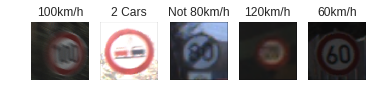

In [0]:
with tf.Session() as sess:
  saver.restore(sess, "/tmp/model_best.ckp")
  n_out_samples = 5 #from 1 to 9
  
  #Show some random data from train
  for i,j in enumerate(np.random.randint(len(images), size=n_out_samples)):
    plt.subplot(100+i+1+10*n_out_samples)
    plt.imshow(images[j])
    plt.axis('off')
    predicted_class = sess.run(y, feed_dict={x: [images[j]], keep_prob: 1.0}).argmax()
    plt.title(class_names[predicted_class])
  plt.show()